# Intro

In Data Explorations notebook I explored the Titanic Data set and didsome feature extraction. Lets test some prediction models!

# Predictions

Lets do some machine learning to see what kind of accuracy we can achive playing around with the data we have so far.

In [1]:
import pandas as pd
import numpy as np
import random
import re

In [2]:
def regex_extract(s, regex, capture_group=1):
    search = re.search(regex, s)
    if search:
        return search.group(capture_group)
    else:
        return None

## Framework
Before we start builiding models, lets set up a simple framework to test and evaluate them with.

In [3]:
import itertools

class Classifier(object):
    
    def predict(row):
        return None

# Extract the features I liked the most from the Data Exploration notebook
def prepare_training_data(training_data):
    data = training_data.copy()
    data['Title'] = data['Name'].apply(lambda x: regex_extract(x, ".*\,\s(.*?)\."))
    data['Title'] = data['Title'].apply(lambda x: x if x in ['Mr', 'Mrs', 'Miss', 'Master'] else "Other")
    data['Child'] = data['Age'].apply(lambda x: x < 18)
    data['Child'] = data['Child'].fillna('Unknown')
    
    tickets = data.groupby(['Ticket']).agg({'Survived' : 'sum', 'PassengerId' : 'count'}).rename(columns={'Survived' : 'SurvivedInCompany','PassengerId' : 'CompanySize'}).reset_index()
    data = data.merge(tickets, on = 'Ticket', how = 'left')
    data['SurvivingCompanions'] = data.apply(lambda row: row['SurvivedInCompany'] - row['Survived'], axis=1)
    data['DeadCompanions'] = data.apply(lambda row: row['CompanySize'] - row['SurvivedInCompany'] + row['Survived'], axis=1)
    
    return data

# Extract features from the test set as well!
def prepare_test_data(test_data, training_data):
    data = test_data.copy()
    data['Title'] = data['Name'].apply(lambda x: regex_extract(x, ".*\,\s(.*?)\."))
    data['Title'] = data['Title'].apply(lambda x: x if x in ['Mr', 'Mrs', 'Miss', 'Master'] else "Other")
    data['Child'] = data['Age'].apply(lambda x: x < 18)
    data['Child'] = data['Child'].fillna('Unknown')
    
    tickets = training_data.groupby(['Ticket']).agg({'Survived' : 'sum', 'PassengerId' : 'count'}).rename(columns={'Survived' : 'SurvivedInCompany','PassengerId' : 'CompanySize'}).reset_index()
    data = data.merge(tickets, on = 'Ticket', how = 'left')
    data['SurvivedInCompany'] = data['SurvivedInCompany'].fillna(0)
    data['CompanySize'] = data['CompanySize'].fillna(0)
    data['SurvivingCompanions'] = data.apply(lambda row: row['SurvivedInCompany'], axis=1)
    data['DeadCompanions'] = data.apply(lambda row: row['CompanySize'] - row['SurvivedInCompany'], axis=1)
    return data
    
def evaluate_model(model, test_data, target="Survived", evaluate=False):
    predictions = test_data.apply(model.predict, axis = 1)
    if evaluate:
        correct = n = 0.0
        for ans, pred in zip(test_data[target], predictions):
            n+= 1
            if ans == pred:
                correct += 1
        print("Accuracy on {} samples: {}".format(n, correct/n))
        return
    else:
        return zip(test_data['PassengerId'], predictions)

Lets prepare some training and test data!

In [4]:
data = pd.read_csv('titanic_train.csv')

In [5]:
# generate a random test set with 25% of all values
import random
random.seed(1)
train_index = []
test_index = []
for i in range(len(data)):
    if random.random() > 0.75:
        test_index.append(i)
    else:
        train_index.append(i)

In [6]:
training_data = data.iloc[train_index]
test_data = data.iloc[test_index]

## Baseline - Naive Bayes

We consider all variables independant and calculate the probability of survival as the mean survival rate for the given variable. We then uses Bayes theorem to calculate P(survival | independant variables). 

I will disregard quantitative variables for now as they require more work (Normalization etc.). I will classify any variable with small number of distinct values as categorical. (And ignore variables with high number of distinct values such as First name)

In [7]:
class NaiveBayes(Classifier):
    def __init__(self, survival_rate, input_variables, prob_dict):
        self.survival_rate = survival_rate
        self.input_variables = input_variables
        self.prob_dict = prob_dict
    
    def predict(self, row):
        prob_survival = np.log(self.survival_rate)
        prob_dead = np.log(1-self.survival_rate)
        for variable in self.input_variables:
            try:
                prob_survival += np.log(self.prob_dict[variable][row[variable]])
                prob_dead += np.log(1 - self.prob_dict[variable][row[variable]])
            except(KeyError):
                pass
        return 1 if prob_survival > prob_dead else 0

    @classmethod
    def train(cls, data, categorical_variables, target, k=1):
        prob_dict = {}
        for variable in categorical_variables:
            prob_dict[variable] = {}
            for distinct_value in data[variable].unique():
                df = data[data[variable] == distinct_value]
                prob_dict[variable][distinct_value] = (df[target].sum() + k) / (df[target].count() + 2 * k)
        return cls(data[target].mean(), categorical_variables, prob_dict)
    

In [8]:
naive_training = prepare_training_data(training_data)
naive_test = prepare_test_data(test_data, training_data)

In [9]:
categorical_variables = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title', 'Child', 'SurvivingCompanions', 'DeadCompanions']

In [10]:
naive_bayes_companion_features = NaiveBayes.train(naive_training, categorical_variables, "Survived")
naive_bayes_base = NaiveBayes.train(naive_training,  ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title', 'Child'], "Survived")
naive_bayes_two_features = NaiveBayes.train(naive_training, ['Pclass', 'Sex'], "Survived")

In [11]:
print("With companion features:")
evaluate_model(naive_bayes_companion_features, naive_test, target="Survived", evaluate=True)
print("Without companions features:")
evaluate_model(naive_bayes_base, naive_test, target="Survived", evaluate=True)
print("Only Pclass and Sex:")
evaluate_model(naive_bayes_two_features, naive_test, target="Survived", evaluate=True)

With companion features:
Accuracy on 233.0 samples: 0.703862660944206
Without companions features:
Accuracy on 233.0 samples: 0.7124463519313304
Only Pclass and Sex:
Accuracy on 233.0 samples: 0.7639484978540773


We got a baseline of 76% to beat!

More features seem to be a poor addition so far, but will likely have more effect with models that do not assume the input variables to be independant.

## Maximum entropy classifier

Classifier from old university lab

In [12]:
def softmax(X):
    """Computes the softmax function for the specified batch of data.

    This uses a common trick to improve numerical stability; this trick is
    explained here:

    http://stackoverflow.com/a/39558290
    """
    E = np.exp(X - np.max(X, axis=1, keepdims=True))
    return E / E.sum(axis=1, keepdims=True)

def minibatches(X, Y, batch_size):
    """Yields minibatches from the specified X and Y matrices.

    Instead of computing updates on the complete data, it is a good idea
    to only compute them on parts of the data; these parts are called
    minibatches. This function randomly splits the input data into
    minibatches of the specified size.
    """
    m = X.shape[0]
    n_batches = int(np.floor(m / batch_size))
    np.random.seed(1)
    random_indices = np.random.permutation(np.arange(m))
    for i in range(n_batches):
        batch_indices = np.arange(i * batch_size, (i + 1) * batch_size)
        batch_indices = random_indices[batch_indices]
        yield X[batch_indices], Y[batch_indices]

class MaxentClassifier(object):

    def __init__(self, n_features, n_classes):
        self.W = np.zeros((n_features, n_classes))

    def p(self, X):
        """Returns the class probabilities for the given input."""

        return softmax(np.dot(X,self.W))

    def predict(self, X):
        """Returns the most probable class for the given input"""
        activation = np.dot(X,self.W)

        return np.argmax(activation, axis=1)

    @classmethod
    def train(cls, X, Y, n_epochs=1, batch_size=1, eta=0.01, reg=0.1):
        classifier = cls(X.shape[1], Y.shape[1])

        for e in range(n_epochs):
            for batch in minibatches(X,Y,batch_size):
                classifier.W = classifier.W + eta*(np.dot(np.transpose(batch[0]), \
                    (batch[1] - classifier.p(batch[0]))) - reg*classifier.W)

        return classifier

In [42]:
def generate_X_Y(trainf_df, test_df):
    X_train = trainf_df.drop('Survived', axis = 1).values
    X_test = test_df.drop('Survived', axis = 1).values
    # Create dummies for Y [0, 1] = Survived [1, 0] = Dead
    Y_train = np.zeros(shape = (len(trainf_df), 2))
    for i, x in enumerate(trainf_df['Survived'].values):
        Y_train[i][x] = 1
    Y_test = np.zeros(shape = (len(test_df), 2))
    for i, x in enumerate(test_df['Survived'].values):
        Y_test[i][x] = 1
    X_train = X_train.astype(float)
    X_test = X_test.astype(float)
    Y_train = Y_train.astype(float)
    Y_test = Y_test.astype(float)
    
    return X_train, X_test, Y_train, Y_test


In [43]:
def accuracy(Y, Y_hat):
    correct = n = 0.0
    for ans, pred in zip(Y, Y_hat):
        n+= 1
        if ans[pred]:
            correct += 1
    print("Accuracy on {} samples: {}".format(n, correct/n))

## First try with the maximum entropy classifer!
Let try with our favourite variables!

In [44]:
variables = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title', 'Child', 'SurvivingCompanions', 'DeadCompanions']

In [45]:
maxent_train = prepare_training_data(training_data)[variables + ['Survived']]
maxent_test = prepare_test_data(test_data, training_data)[variables + ['Survived']]

maxent_train = pd.get_dummies(maxent_train)
maxent_test = pd.get_dummies(maxent_test)

In [64]:
X_train, X_test, Y_train, Y_test = generate_X_Y(maxent_train, maxent_test)
maxent_classifier = MaxentClassifier.train(X_train, Y_train, batch_size = 10, n_epochs=10)
Y_hat = maxent_classifier.predict(X_test)
accuracy(Y_test, Y_hat)

Accuracy on 233.0 samples: 0.8283261802575107


In [48]:
from sklearn.metrics import confusion_matrix

In [66]:
test_Y = list(map(np.argmax, Y_test))

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

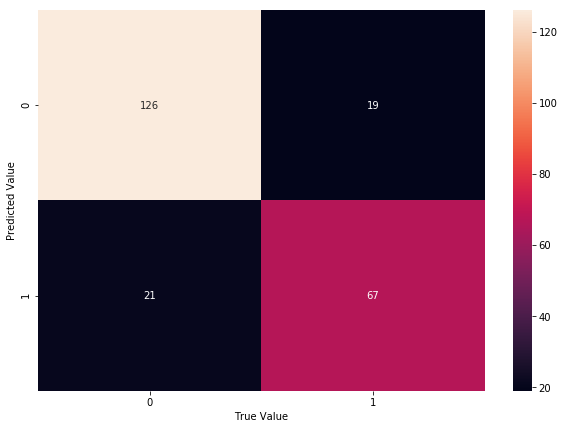

In [67]:
confusing_matrix_df = pd.DataFrame(confusion_matrix(test_Y, Y_hat))
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(confusing_matrix_df, annot=True, fmt=".0f", ax = ax)
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')

Improved accuracy! Woho!

Lets check out the weight matrix.

In [29]:
features = maxent_train.drop('Survived', axis=1).columns

In [36]:
pd.DataFrame(index=features, data=maxent_classifier.W, columns=['Dead', 'Survived']).sort_values('Dead')

,Dead,Survived
Sex_female,-0.764988,0.764988
SurvivingCompanions,-0.461305,0.461305
Title_Mrs,-0.443335,0.443335
Title_Master,-0.441814,0.441814
Embarked_C,-0.363600,0.363600
Child,-0.272675,0.272675
Title_Miss,-0.251113,0.251113
Embarked_S,-0.215614,0.215614
Embarked_Q,-0.205187,0.205187
Sex_male,-0.040051,0.040051


SibSp, Parch, Sex_male and Title_Other have very low values. This means they contribute little to the outcome. Ltes try to drop them! (Intuitively it seems like a bad move to drop just some values of a categorical, but lets experiment!)

For the ordinal variables SibSp and Parch this might also be misguided, as potentially their weight can contribute more when they have higher values.

## Second go, dropping variables with low impact

In [40]:
# Remove SibSP, Parch, Sex_male and Title_Other
remove_indexes = [1, 2, 7, 15]
mask = [False if i in remove_indexes else True for i in range(16)]

In [43]:
X_train, X_test, Y_train, Y_test = generate_X_Y(maxent_train, maxent_test)
X_train = X_train[:,mask]
X_test = X_test[:,mask]
maxent_classifier = MaxentClassifier.train(X_train, Y_train, batch_size = 10, n_epochs=10)
Y_hat = maxent_classifier.predict(X_test)
accuracy(Y_test, Y_hat)

Accuracy on 233.0 samples: 0.8240343347639485


Almost the same accuracy! Lets try keeping our ordinal variables.

In [44]:
# Remove SibSP, Parch, Sex_male and Title_Other
remove_indexes = [7, 15]
mask = [False if i in remove_indexes else True for i in range(16)]

In [45]:
X_train, X_test, Y_train, Y_test = generate_X_Y(maxent_train, maxent_test)
X_train = X_train[:,mask]
X_test = X_test[:,mask]
maxent_classifier = MaxentClassifier.train(X_train, Y_train, batch_size = 10, n_epochs=10)
Y_hat = maxent_classifier.predict(X_test)
accuracy(Y_test, Y_hat)

Accuracy on 233.0 samples: 0.8283261802575107


Shady business removing some categories of our ordinals, and we don't seem to achieve better results.

# Lets try the actual test set!
My feature `Surviving Companions` should be more effectfull with more data in the training set. Lets see what results I get!

In [56]:
training_data_ = pd.read_csv('titanic_train.csv')
test_data_ = pd.read_csv('titanic_test.csv')

In [57]:
variables = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title', 'Child', 'SurvivingCompanions', 'DeadCompanions']

In [58]:
training_data = prepare_training_data(training_data_)[variables + ['Survived']]
test_data = prepare_test_data(test_data_, training_data_)[variables]

In [60]:
maxent_train = pd.get_dummies(training_data)
maxent_test = pd.get_dummies(test_data)

In [68]:
X_train, X_test, Y_train, Y_test = generate_X_Y(maxent_train, maxent_test)
maxent_classifier = MaxentClassifier.train(X_train, Y_train, batch_size = 10, n_epochs=10)
Y_hat = maxent_classifier.predict(X_test)

In [79]:
pd.DataFrame(index = test_data_['PassengerId'], data=Y_hat, columns=['Survived']).to_csv('titanic_submission1.csv')

Result: **0.80382 test score**. I can do better!  

I want to improve on these fronts:
* Explore and improve my features
* Investigate crossvalidation as a means of tuning my model parameters
* Test other predictive models

I will continue in another notebook!